The RandomizedLogisticRegression is not stable between kernels.
Just create a notebook and do all the analysis + print output to files,
So yoiu won't have problem on making the figures

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Read HDF file and phenotypes

In [3]:
final_SNPs = pd.read_hdf('data/BeanCAP_MDP_genotype_data.hdf5', 'snptable')
pheno_all = pd.read_csv('data/Adjusted-means-for-Agronomic-traits-with-race-and-market-calss-info.txt',
                       sep = '\t', header=0)
pheno_all.head()

,supop,market_class,taxa,df_co,dm_co,ch_co,lg_co,gh_co,sw_co,df_mi,...,dm_ne,ch_ne,lg_ne,sw_ne,df,dm,ch,lg,gh,sw
0,MA,black,115m,49,92,50,4,2,20.0,41,...,96,41,4,20.5,49,102,45,3.67,2.5,21.5
1,DJ,pink,6r_42,46,90,41,5,3,29.9,38,...,101,40,5,30.5,47,103,37,5.00,3.0,32.3
2,MA,black,92bg_7,49,87,48,3,3,22.8,44,...,79,33,2,21.7,50,92,39,2.33,2.5,21.7
3,DJ,pinto,92us_1006,46,82,45,1,2,30.3,38,...,78,45,1,29.2,45,90,43,1.33,2.0,31.3
4,MA,cream_caroca,a_285,51,94,55,3,3,22.2,45,...,95,40,3,20.9,52,103,48,3.00,2.5,23.1


Since it is the first analysis I will do some data exploration

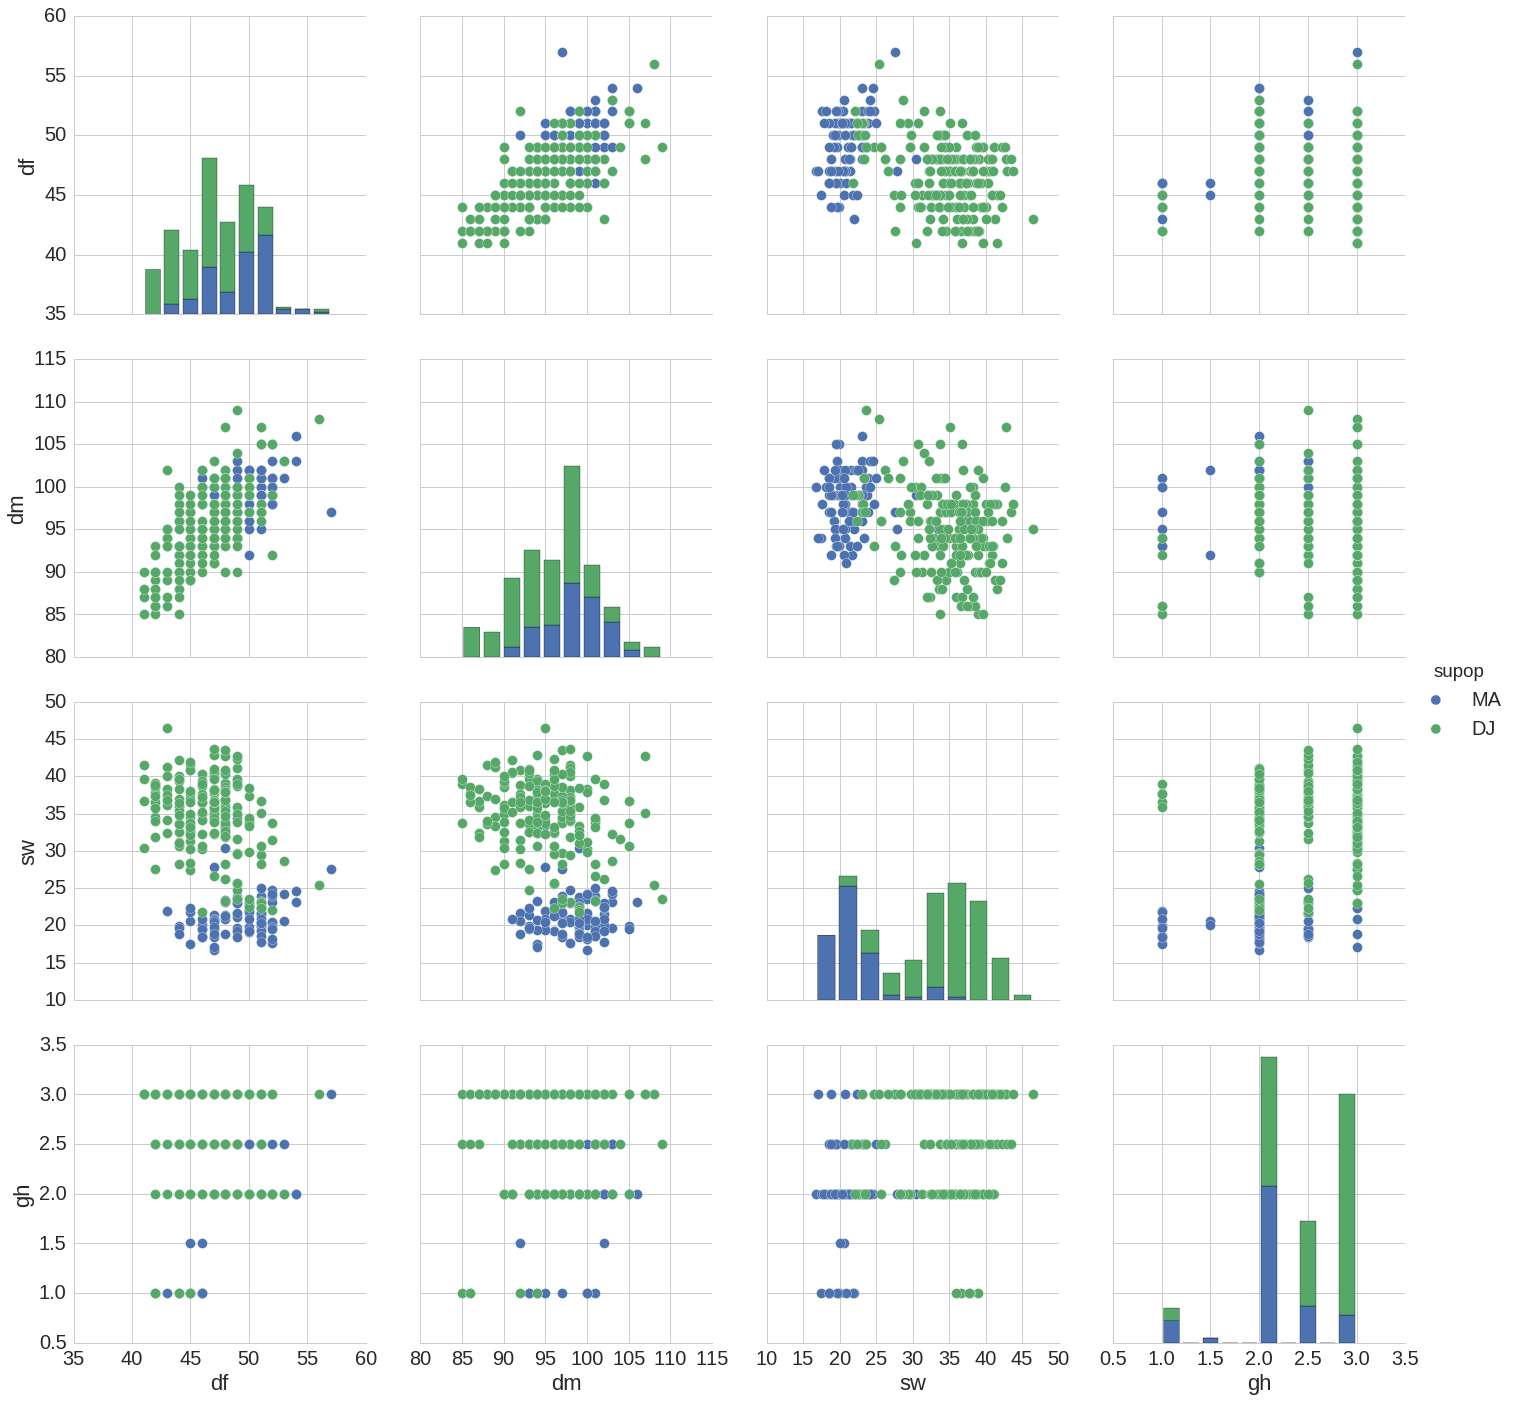

In [4]:
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.pairplot(pheno_all[['df', 'dm', 'sw', 'gh', 'supop']], hue='supop', size=5, 
             plot_kws={'s':100});

### 3 class plots

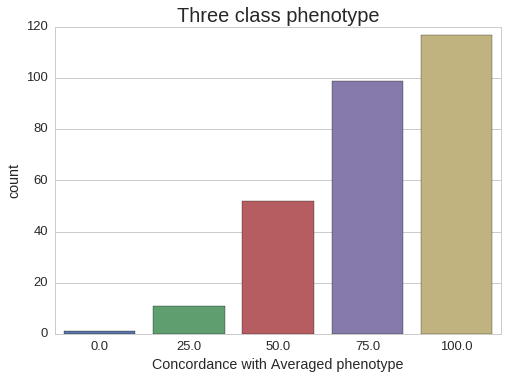

In [30]:
def multi_class(dataframe):
    l=[]
    for i in dataframe.columns:
        l.append(pd.qcut(dataframe[i], q=[0,.25, .75, 1], labels = False))
    return l

df_data = pheno_all[['df', 'df_co', 'df_mi','df_ne', 'df_nd']]
cl = multi_class(df_data)
cl_data = pd.DataFrame(cl).T
#sns.heatmap(cl_data)

avg = cl_data['df']
cl_data2 = cl_data.drop('df', axis=1)

l = []
for i in cl_data2.columns:
    l.append(cl_data2[i]==avg)
    
    
    
def get_perc(i):
    return (np.sum(i)/4)*100

sns.set(font_scale=1.3)
sns.set_style('whitegrid')
new = pd.DataFrame(l).T
x = new.apply(get_perc, axis=1)
sns.countplot(x)
plt.title('Three class phenotype', fontsize=20)
plt.xlabel('Concordance with Averaged phenotype');
    


### Early

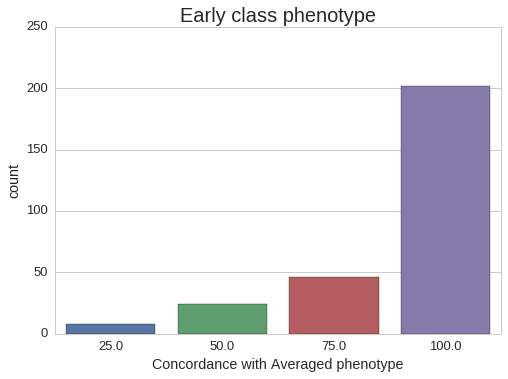

In [31]:
def multi_class(dataframe):
    l=[]
    for i in dataframe.columns:
        l.append(pd.qcut(dataframe[i], q=[0,.25, 1], labels = False))
    return l

df_data = pheno_all[['df', 'df_co', 'df_mi','df_ne', 'df_nd']]
cl = multi_class(df_data)
cl_data = pd.DataFrame(cl).T
#sns.heatmap(cl_data)

avg = cl_data['df']
cl_data2 = cl_data.drop('df', axis=1)

l = []
for i in cl_data2.columns:
    l.append(cl_data2[i]==avg)
    
    
    
def get_perc(i):
    return (np.sum(i)/4)*100

sns.set(font_scale=1.3)
sns.set_style('whitegrid')
new = pd.DataFrame(l).T
x = new.apply(get_perc, axis=1)
sns.countplot(x)
plt.title('Early class phenotype', fontsize=20)
plt.xlabel('Concordance with Averaged phenotype');
    

### Late

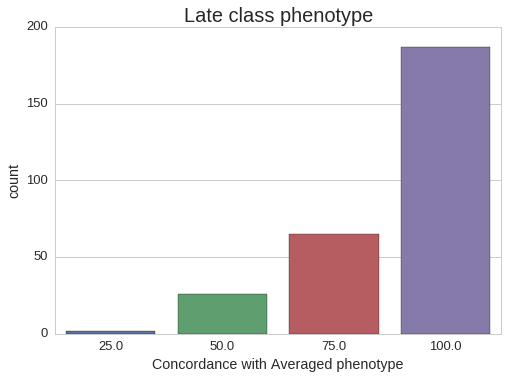

In [40]:
def multi_class(dataframe):
    l=[]
    for i in dataframe.columns:
        l.append(pd.qcut(dataframe[i], q=[0,.75, 1], labels = False))
    return l

df_data = pheno_all[['df', 'df_co', 'df_mi','df_ne', 'df_nd']]
cl = multi_class(df_data)
cl_data = pd.DataFrame(cl).T
#sns.heatmap(cl_data)

avg = cl_data['df']
cl_data2 = cl_data.drop('df', axis=1)

l = []
for i in cl_data2.columns:
    l.append(cl_data2[i]==avg)
    
    
    
def get_perc(i):
    return (np.sum(i)/4)*100

sns.set(font_scale=1.3)
sns.set_style('whitegrid')
new = pd.DataFrame(l).T
x = new.apply(get_perc, axis=1)
sns.countplot(x)
plt.title('Late class phenotype', fontsize=20)
plt.xlabel('Concordance with Averaged phenotype');
    

# All collection

Prepare phenotypes and genotypes for ML training

I will use the cross_val_score with **scorer='precision_micro'** for the classification. Then I will plot two graphs (1 DF and 1 DM) with mean +- std of the cv values (use 5 cv)

Create funcion with all the data in the model_prescreen script. N.B. for precision you should use a `make_scorer(precision_score, average=average)` like for precision_recall curve.
return a dataframe with all the prediction x classifier, so you can plot it with seaborn point_plot

I will analyze
1. Early (25 %)
2. Late (75 %)
3. 3 Classes

In [5]:
# import custom module
from classification_prescreen import classification_task_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.feature_selection import SelectPercentile, SelectKBest, SelectFromModel, chi2, f_classif
from sklearn.metrics import make_scorer, precision_score

## Feature selection approach

In [26]:
def feature_selector(X,y):
    selector = SelectPercentile(f_classif, percentile=1)
    selector.fit(X,y)
    return selector

#def feature_selector(X,y,model):
#    model.fit(X,y)
#    selector = SelectFromModel(model,threshold = 0.00001, prefit=True)
#    return selector

## Stratify byclass

## Early 25%

In [27]:
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.25, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)



X_train_s = feature_selector(X_train, y_train).transform(X_train)

# use of precision for earliness
prec_early = make_scorer(precision_score, average='binary', pos_label=0)
print(X_train_s.shape)
classification_prescreen_early = classification_task_score(X_train_s, y_train, 
                                                     strat=y_train, scorer=prec_early,
                                                           cv = 5, jobs=7)

(224, 2436)
Processing SVC model 1 of 9
Processing linearSVC model 2 of 9
Processing RandomForest model 3 of 9
Processing KNeighbors model 4 of 9
Processing LogisticRegression model 5 of 9
Processing Bagging model 6 of 9
Processing MLP model 7 of 9
Processing SGD model 8 of 9
Processing GradientBoosting model 9 of 9


## Late 25

In [28]:
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.75, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)


X_train_s = feature_selector(X_train, y_train).transform(X_train)
print(X_train_s.shape)

prec_late = make_scorer(precision_score, average='binary', pos_label=1)
classification_prescreen_late = classification_task_score(X_train_s, y_train, 
                                                     strat=y_train, scorer=prec_late,
                                                          cv = 5, jobs=7)

(224, 2409)
Processing SVC model 1 of 9
Processing linearSVC model 2 of 9
Processing RandomForest model 3 of 9
Processing KNeighbors model 4 of 9
Processing LogisticRegression model 5 of 9
Processing Bagging model 6 of 9
Processing MLP model 7 of 9
Processing SGD model 8 of 9
Processing GradientBoosting model 9 of 9


## 3 classes

In [29]:
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.25, .75, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)


X_train_s = feature_selector(X_train, y_train).transform(X_train)
print(X_train_s.shape)

classification_prescreen_all = classification_task_score(X_train_s, y_train, 
                                                     strat=y_train, scorer='precision_macro',
                                                         cv = 5, jobs=7)

(224, 2434)
Processing SVC model 1 of 9
Processing linearSVC model 2 of 9
Processing RandomForest model 3 of 9
Processing KNeighbors model 4 of 9
Processing LogisticRegression model 5 of 9
Processing Bagging model 6 of 9
Processing MLP model 7 of 9
Processing SGD model 8 of 9
Processing GradientBoosting model 9 of 9


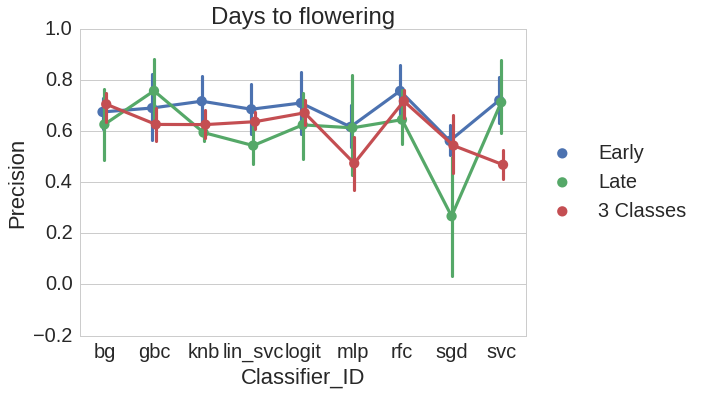

In [31]:
# plot both
import numpy as np
sns.set(font_scale=2)
sns.set_style("whitegrid")
classification_prescreen_early['Class']=np.repeat('Early', classification_prescreen_early.shape[0])
classification_prescreen_late['Class']=np.repeat('Late', classification_prescreen_late.shape[0])
classification_prescreen_all['Class']=np.repeat('3 Classes', classification_prescreen_all.shape[0])
classification_df = pd.concat([classification_prescreen_early, 
                       classification_prescreen_late, classification_prescreen_all])


sns.pointplot(x='Classifier_ID', y='Score', hue='Class',
                   data = classification_df, dodge=True)
plt.ylabel('Precision')
plt.title('Days to flowering')
#plt.ylim((0,1))
plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5));

In [32]:
# save DF to file so you can plot again later
classification_df.to_csv('CV_DF_prediction_f1_classification_scores.csv', sep=',', header=True, index=False)

It seems that the best performance is similar across classes
I will try to improve the model with the 3 classes using different approaches:

1. Logit

2. Random Forest

3. GBC


# Prepare data 3 classes

## Flowering Average

In [30]:
# import custom module
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_predict
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import precision_score, classification_report, make_scorer
from scipy import stats

In [54]:
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.25, .75, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)


def feature_selector(X,y):
    selector = SelectKBest(f_classif, k=2000)
    selector.fit(X,y)
    return selector

selector = feature_selector(X_train, y_train)
X_train_s = selector.transform(X_train)
print(X_train_s.shape)

(224, 2000)


In [55]:
import tensorflow as tf

def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

config = tf.contrib.learn.RunConfig(tf_random_seed=42)
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[500, 100, 50, 10], n_classes=3,
                                        feature_columns=feature_columns, config=config,
                                        activation_fn=tf.nn.relu, enable_centered_bias=True)

dnn_clf = tf.contrib.learn.SKCompat(dnn_clf)

INFO:tensorflow:Using config: {'_save_summary_steps': 100, '_task_type': None, '_environment': 'local', '_evaluation_master': '', '_task_id': 0, '_tf_random_seed': 42, '_keep_checkpoint_every_n_hours': 10000, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_keep_checkpoint_max': 5, '_save_checkpoints_steps': None, '_num_worker_replicas': 0, '_model_dir': '/tmp/tmp5mk3ih8j', '_num_ps_replicas': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb1c3fb0550>, '_save_checkpoints_secs': 600, '_session_config': None, '_is_chief': True, '_master': ''}


In [56]:
dnn_clf.fit(x=X_train_s, y=y_train, batch_size=10, steps=2000)

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp5mk3ih8j/model.ckpt.
INFO:tensorflow:step = 1, loss = 1.15425
INFO:tensorflow:global_step/sec: 218.262
INFO:tensorflow:step = 101, loss = 0.578077 (0.459 sec)
INFO:tensorflow:global_step/sec: 223.7
INFO:tensorflow:step = 201, loss = 0.527937 (0.447 sec)
INFO:tensorflow:global_step/sec: 223.653
INFO:tensorflow:step = 301, loss = 0.796217 (0.447 sec)
INFO:tensorflow:global_step/sec: 223.401
INFO:tensorflow:step = 401, loss = 0.902658 (0.448 sec)
INFO:tensorflow:global_step/sec: 218.262
INFO:tensorflow:step = 501, loss = 0.984785 (0.458 sec)
INFO:tensorflow:global_step/

SKCompat()

In [58]:
from sklearn.metrics import precision_score, classification_report

X_test_s = selector.transform(X_test)
y_pred = dnn_clf.predict(X_test_s)
print(precision_score(y_test, y_pred['classes'], average='macro'))
print(classification_report(y_test, y_pred['classes']))

INFO:tensorflow:Restoring parameters from /tmp/tmp5mk3ih8j/model.ckpt-2000
0.480134680135
             precision    recall  f1-score   support

          0       0.82      0.56      0.67        16
          1       0.62      0.93      0.75        30
          2       0.00      0.00      0.00        10

avg / total       0.57      0.66      0.59        56



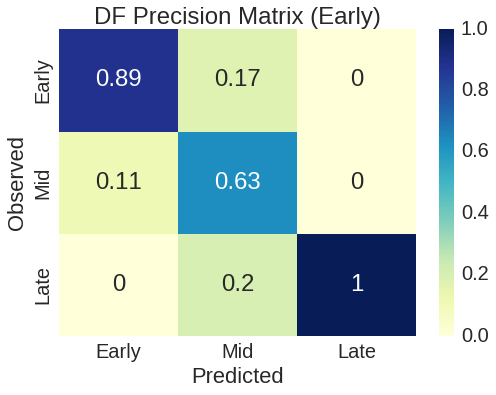

In [44]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred['classes'])
norm_matrix = conf_matrix/conf_matrix.sum(axis=0, keepdims=True)
sns.heatmap(norm_matrix, cmap='YlGnBu', annot=True,
          xticklabels=['Early', 'Mid', 'Late'], yticklabels=['Early', 'Mid', 'Late'],
           vmin=0, vmax=1)
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.title("DF Precision Matrix (Early)");

In [46]:
locations = ['df_co', 'df_mi','df_ne', 'df_nd']
states = ['Colorado', 'Minnesota', 'Nebraska', 'North Dakota']


def feature_selector(X,y):
    selector = SelectKBest(f_classif, k=2000)
    selector.fit(X,y)
    return selector
x=101
for colname, station in zip(locations, states):
    print(colname)
    df = pheno_all[colname]
    df_classes = pd.qcut(df, q=[0,.25,.75, 1], labels = False)
    y = df_classes.values
    X = final_SNPs.values

    #X_train, X_test, y_train, y_test = train_test_split(X, y,
    #                                               test_size = 0.2,
    #                                               stratify = y,
                                                  # random_state = x)
    selector = feature_selector(X, y)
    X_s = selector.transform(X)
    print(X_s.shape)
    # nn
    #config = tf.contrib.learn.RunConfig(tf_random_seed=x)
    #feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)
    #dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[500, 100, 50, 10], n_classes=3,
                                        #feature_columns=feature_columns, config=config,
                                        #activation_fn=selu, enable_centered_bias=True)
   # net_clf = tf.contrib.learn.SKCompat(dnn_clf)
    #net_clf.fit(x=X_train_s, y=y_train, batch_size=10, steps=2000)
    # evaluate predictions
    #X_test_s = selector.transform(X_test)
    y_pred = dnn_clf.predict(X_s)
    print(station)
    print(precision_score(y, y_pred['classes'], average='macro'))
    print(classification_report(y, y_pred['classes']))
    x+=1
    # plot

df_co
(280, 2000)
INFO:tensorflow:Restoring parameters from /tmp/tmpogyxpwp1/model.ckpt-2000
Colorado
0.45303030303
             precision    recall  f1-score   support

          0       0.85      0.55      0.67        92
          1       0.51      0.93      0.66       121
          2       0.00      0.00      0.00        67

avg / total       0.50      0.58      0.50       280

df_mi
(280, 2000)
INFO:tensorflow:Restoring parameters from /tmp/tmpogyxpwp1/model.ckpt-2000
Minnesota
0.154351395731
             precision    recall  f1-score   support

          0       0.03      0.07      0.05        76
          1       0.43      0.37      0.40       155
          2       0.00      0.00      0.00        49

avg / total       0.25      0.22      0.23       280

df_ne
(280, 2000)
INFO:tensorflow:Restoring parameters from /tmp/tmpogyxpwp1/model.ckpt-2000
Nebraska
0.75884165821
             precision    recall  f1-score   support

          0       0.66      0.86      0.75        76
       

## Maturity

In [336]:
df = pheno_all['dm']
df_classes = pd.qcut(df, q=[0,.25,.75, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)


def feature_selector(X,y):
    selector = SelectPercentile(f_classif, percentile=2)
    selector.fit(X,y)
    return selector

selector = feature_selector(X_train, y_train)
X_train_s = selector.transform(X_train)
print(X_train_s.shape)

(224, 4872)


In [337]:
import tensorflow as tf

config = tf.contrib.learn.RunConfig(tf_random_seed=42)
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[500, 100, 50, 10], n_classes=3,
                                        feature_columns=feature_columns, activation_fn=tf.nn.relu,
                                         optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1),
                                         config=config)

dnn_clf = tf.contrib.learn.SKCompat(dnn_clf)
dnn_clf.fit(x=X_train_s, y=y_train, batch_size=50, steps=1000)

INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_tf_random_seed': 42, '_model_dir': '/tmp/tmpoqc4h35u', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_task_type': None, '_num_ps_replicas': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7dcf5ab908>, '_num_worker_replicas': 0, '_task_id': 0, '_keep_checkpoint_max': 5, '_is_chief': True, '_environment': 'local', '_master': '', '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_evaluation_master': ''}
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Sa

SKCompat()

In [338]:
from sklearn.metrics import accuracy_score
X_test_s = selector.transform(X_test)
y_pred = dnn_clf.predict(X_test_s)
print(accuracy_score(y_test, y_pred['classes']))
print(precision_score(y_test, y_pred['classes'], average='macro'))
print(classification_report(y_test, y_pred['classes']))

INFO:tensorflow:Restoring parameters from /tmp/tmpoqc4h35u/model.ckpt-1000
0.625
0.603511431098
             precision    recall  f1-score   support

          0       0.69      0.60      0.64        15
          1       0.69      0.71      0.70        28
          2       0.43      0.46      0.44        13

avg / total       0.63      0.62      0.63        56



In [ ]:
import tensorflow as tf

config = tf.contrib.learn.RunConfig(tf_random_seed=42)
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[500, 100, 50, 10], n_classes=3,
                                        feature_columns=feature_columns, activation_fn=tf.nn.relu,
                                         optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1),
                                         config=config)

INFO:tensorflow:Restoring parameters from /tmp/tmpz_xuzkpi/model.ckpt-1000
INFO:tensorflow:Restoring parameters from /tmp/tmpaca39e0j/model.ckpt-1000
0.625
0.603511431098
             precision    recall  f1-score   support

          0       0.69      0.60      0.64        15
          1       0.69      0.71      0.70        28
          2       0.43      0.46      0.44        13

avg / total       0.63      0.62      0.63        56




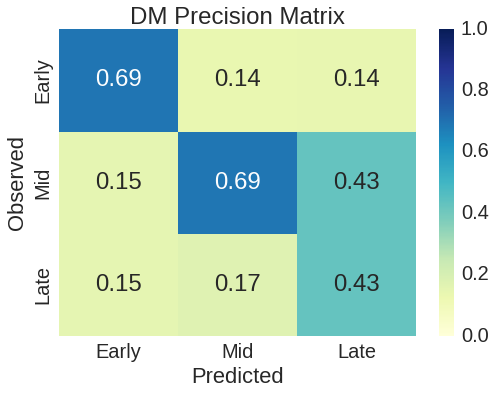

In [312]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred['classes'])
norm_matrix = conf_matrix/conf_matrix.sum(axis=0, keepdims=True)
sns.heatmap(norm_matrix, cmap='YlGnBu', annot=True,
          xticklabels=['Early', 'Mid', 'Late'], yticklabels=['Early', 'Mid', 'Late'],
           vmin=0, vmax=1)
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.title("DM Precision Matrix");